## Import Libraries

In [1]:
import os
import torch
import pickle
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Dataset Class for Email Classification

In [3]:
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


## Neural Network (Embedding + LSTM)

In [4]:
class EmailClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(EmailClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, 
                            bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)
        packed_output, (hidden, cell) = self.lstm(embedded)
        # Use the last hidden state
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        output = self.fc(hidden)
        return self.softmax(output)


## Data Preparation (Train-Test Split and DataLoader)

In [5]:
combined_data = pd.read_csv('data/smartsense data - merged.csv')

In [6]:
# Assume 'combined_data' is your dataset with 'Email' and 'Category' columns
category_mapping = {'student': 0, 'corporate': 1, 'research': 2}
combined_data['Category'] = combined_data['Category'].map(category_mapping)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    combined_data['Email'], combined_data['Category'], test_size=0.2)

train_dataset = EmailDataset(train_texts.tolist(), train_labels.tolist(), tokenizer, max_len=64)
val_dataset = EmailDataset(val_texts.tolist(), val_labels.tolist(), tokenizer, max_len=64)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


## Training Loop

In [7]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs):
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        total_train_loss = 0
        model.train()
        
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss}")
        
        # Validation step
        model.eval()
        total_val_loss = 0
        correct_preds = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask)
                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct_preds += torch.sum(preds == labels)
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = correct_preds.double() / len(val_loader.dataset)
        val_accuracies.append(val_accuracy.item())
        print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss}, Val Accuracy: {val_accuracy}\n")
    
    return train_losses, val_losses, val_accuracies


## Model Initialization and Training

In [8]:
vocab_size = tokenizer.vocab_size
embedding_dim = 128
hidden_dim = 256
output_dim = 3  # student, corporate, research
n_layers = 4
bidirectional = True
dropout = 0.3
epochs = 10

# Initialize model, optimizer, and loss function
model = EmailClassificationModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Train the model
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs)


Epoch 1, Train Loss: 1.0940083675086498
Epoch 1, Val Loss: 1.081544041633606, Val Accuracy: 0.4015748031496063

Epoch 2, Train Loss: 1.0114726182073355
Epoch 2, Val Loss: 0.8428917080163956, Val Accuracy: 0.7795275590551181

Epoch 3, Train Loss: 0.7259964141994715
Epoch 3, Val Loss: 0.6463758796453476, Val Accuracy: 0.937007874015748

Epoch 4, Train Loss: 0.6268892884254456
Epoch 4, Val Loss: 0.6393575742840767, Val Accuracy: 0.9133858267716535

Epoch 5, Train Loss: 0.6165848765522242
Epoch 5, Val Loss: 0.6336862742900848, Val Accuracy: 0.9212598425196851

Epoch 6, Train Loss: 0.5991841349750757
Epoch 6, Val Loss: 0.611235186457634, Val Accuracy: 0.9448818897637795

Epoch 7, Train Loss: 0.5852494910359383
Epoch 7, Val Loss: 0.5961808040738106, Val Accuracy: 0.9606299212598425

Epoch 8, Train Loss: 0.5855065640062094
Epoch 8, Val Loss: 0.6023323461413383, Val Accuracy: 0.9448818897637795

Epoch 9, Train Loss: 0.5684037208557129
Epoch 9, Val Loss: 0.6015586107969284, Val Accuracy: 0.9527

## Plot the Training and Validation Losses/Accuracies

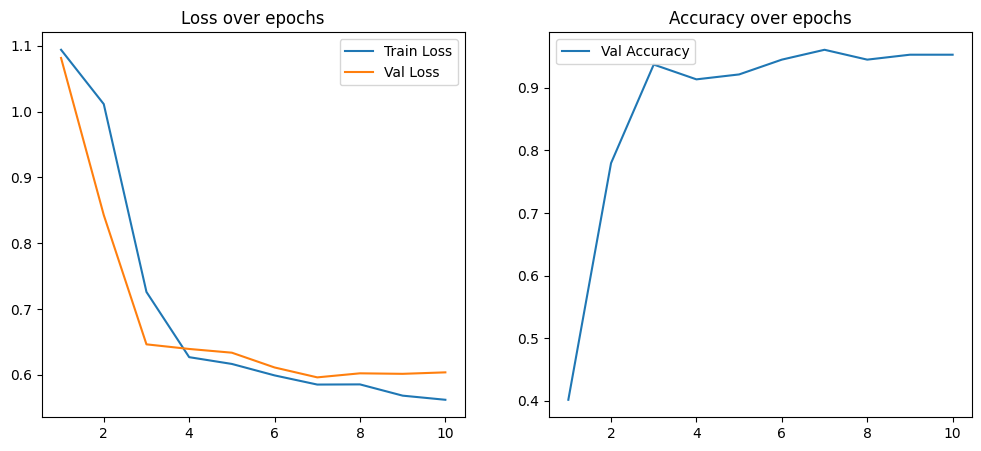

In [9]:
epochs_range = range(1, epochs+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.legend(loc='best')
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.legend(loc='best')
plt.title('Accuracy over epochs')

plt.show()


## valuate Model Performance with Classification Report

In [10]:
val_predictions = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)
        val_predictions.extend(preds.cpu().numpy())

print(classification_report(val_labels, val_predictions, target_names=['student', 'corporate', 'research']))


              precision    recall  f1-score   support

     student       0.97      0.95      0.96        41
   corporate       0.92      0.95      0.94        38
    research       0.96      0.96      0.96        48

    accuracy                           0.95       127
   macro avg       0.95      0.95      0.95       127
weighted avg       0.95      0.95      0.95       127



## Save LSTM Model and Tokenizer

In [11]:
save_directory = "LSTM_model_save"
os.makedirs(save_directory, exist_ok=True)

model_save_path = os.path.join(save_directory, 'lstm_model.pth')
tokenizer_save_path = os.path.join(save_directory, 'tokenizer.pkl')

# Save the model
torch.save(model.state_dict(), model_save_path)

# Save the tokenizer
with open(tokenizer_save_path, 'wb') as f:
    pickle.dump(tokenizer, f)

print(f"Model saved to {model_save_path}")
print(f"Tokenizer saved to {tokenizer_save_path}")

Model saved to LSTM_model_save/lstm_model.pth
Tokenizer saved to LSTM_model_save/tokenizer.pkl


## Load the LSTM Model and Tokenizer

In [13]:
# Load LSTM model
vocab_size = tokenizer.vocab_size
embedding_dim = 128
hidden_dim = 256
output_dim = 3  # student, corporate, research
n_layers = 4
bidirectional = True
dropout = 0.3
epochs = 10

# Initialize model, optimizer, and loss function
model = EmailClassificationModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)

# Load the model's state_dict from the saved file
model.load_state_dict(torch.load('LSTM_model_save/lstm_model.pth'))

# Set the model to evaluation mode for inference
model.eval()
# Load tokenizer
with open(tokenizer_save_path, 'rb') as f:
    loaded_tokenizer = pickle.load(f)

print("Model and Tokenizer loaded successfully!")


Model and Tokenizer loaded successfully!


## Use the Loaded Model for Inference

In [14]:
def predict_email_category(model, emails, tokenizer):
    model.eval()
    predictions = []
    
    for email in emails:
        # Tokenize and encode the email
        encoding = tokenizer.encode_plus(
            email,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)
            predictions.append(preds.item())
    
    return predictions

# Example usage
sample_emails = [
    "Dear Professor, I would like to have corporate partnership with your university.",
]

predicted_labels = predict_email_category(model, sample_emails, tokenizer)
print(predicted_labels)


[2]
